# Custom Decision Tree with Sklearn Pipeline

**Focus:** Custom decision tree implementation with sklearn preprocessing/features

**Pipeline:**
1. ✅ Sklearn preprocessing (SimpleImputer)
2. ✅ Feature engineering (statistical + temporal)
3. ✅ Sklearn feature selection (mutual information)
4. ✅ **CUSTOM decision tree** (core contribution)
5. ✅ Compare with sklearn DecisionTreeClassifier

**Dataset:** Scania Component X (Version 2)
- Training: 23,550 vehicles (90.4% healthy, 9.6% failed)
- Validation: 5,046 vehicles (binary conversion from 5 classes)

---
## 1. Setup

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
%matplotlib inline

print("✅ Libraries imported")

✅ Libraries imported


---
## 2. Load Data

In [23]:
print("📂 Loading raw data...")
train_ops = pd.read_csv('../data/raw/train_operational_readouts.csv')
val_ops = pd.read_csv('../data/raw/validation_operational_readouts.csv')
train_tte = pd.read_csv('../data/raw/train_tte.csv')
val_labels = pd.read_csv('../data/raw/validation_labels.csv')

print(f"✅ Data loaded:")
print(f"   Train ops: {train_ops.shape}")
print(f"   Val ops: {val_ops.shape}")
print(f"   Train labels: {train_tte.shape}")
print(f"   Val labels: {val_labels.shape}")
print(f"   Missing values: {train_ops.isnull().sum().sum():,} train + {val_ops.isnull().sum().sum():,} val")

📂 Loading raw data...
✅ Data loaded:
   Train ops: (1122452, 107)
   Val ops: (196227, 107)
   Train labels: (23550, 3)
   Val labels: (5046, 2)
   Missing values: 354,634 train + 60,339 val


---
## 3. Preprocessing (Sklearn SimpleImputer)

In [24]:
print("🔧 PREPROCESSING: Sklearn SimpleImputer with median strategy")
start_time = time.time()

# Identify sensor columns
id_cols = ['vehicle_id', 'time_step']
sensor_cols = [col for col in train_ops.columns if col not in id_cols]

# Sklearn median imputation
imputer = SimpleImputer(strategy='median')
imputer.fit(train_ops[sensor_cols])

train_ops_processed = train_ops.copy()
val_ops_processed = val_ops.copy()

train_ops_processed[sensor_cols] = imputer.transform(train_ops[sensor_cols])
val_ops_processed[sensor_cols] = imputer.transform(val_ops[sensor_cols])

preproc_time = time.time() - start_time

print(f"✅ Preprocessing complete! ({preproc_time:.2f}s)")
print(f"   Missing after: {train_ops_processed.isnull().sum().sum()} train + {val_ops_processed.isnull().sum().sum()} val")

🔧 PREPROCESSING: Sklearn SimpleImputer with median strategy
✅ Preprocessing complete! (17.70s)
   Missing after: 0 train + 0 val


---
## 4. Feature Engineering

In [25]:
def create_statistical_features(df, sensor_cols):
    """Create statistical features using pandas aggregation"""
    agg_dict = {}
    for col in sensor_cols:
        if col in df.columns and col not in ['vehicle_id', 'time_step']:
            agg_dict[f'{col}_mean'] = (col, 'mean')
            agg_dict[f'{col}_median'] = (col, 'median')
            agg_dict[f'{col}_std'] = (col, 'std')
            agg_dict[f'{col}_min'] = (col, 'min')
            agg_dict[f'{col}_max'] = (col, 'max')
    return df.groupby('vehicle_id').agg(**agg_dict).reset_index()

def create_temporal_features(df, sensor_cols):
    """Create temporal features for cumulative sensors"""
    temporal_features = []
    cumulative_sensors = [col for col in sensor_cols if '167_' in col]
    
    for vehicle_id, group in df.groupby('vehicle_id'):
        vehicle_features = {'vehicle_id': vehicle_id}
        for col in cumulative_sensors:
            if col in group.columns:
                values = group[col].values
                vehicle_features[f'{col}_last'] = values[-1]
                if len(values) > 1:
                    x = np.arange(len(values))
                    slope = np.polyfit(x, values, 1)[0]
                    vehicle_features[f'{col}_trend'] = slope
                else:
                    vehicle_features[f'{col}_trend'] = 0
                vehicle_features[f'{col}_volatility'] = np.std(values)
        temporal_features.append(vehicle_features)
    return pd.DataFrame(temporal_features)

print("✅ Feature engineering functions defined")

✅ Feature engineering functions defined


In [26]:
print("🔧 Creating features...")
start_time = time.time()

# Statistical features
train_stat = create_statistical_features(train_ops_processed, sensor_cols)
val_stat = create_statistical_features(val_ops_processed, sensor_cols)

# Temporal features
train_temp = create_temporal_features(train_ops_processed, sensor_cols)
val_temp = create_temporal_features(val_ops_processed, sensor_cols)

# Merge
X_train_features = train_stat.merge(train_temp, on='vehicle_id', how='inner')
X_val_features = val_stat.merge(val_temp, on='vehicle_id', how='inner')

# Add labels
X_train_features = X_train_features.merge(train_tte[['vehicle_id', 'in_study_repair']], on='vehicle_id')
X_val_features = X_val_features.merge(val_labels[['vehicle_id', 'class_label']], on='vehicle_id')

# Convert validation labels from 5 classes to binary
X_val_features['in_study_repair'] = (X_val_features['class_label'] > 0).astype(int)
X_val_features.drop('class_label', axis=1, inplace=True)

# Extract X and y
y_train = X_train_features['in_study_repair'].values
y_val = X_val_features['in_study_repair'].values
X_train = X_train_features.drop(['vehicle_id', 'in_study_repair'], axis=1).values
X_val = X_val_features.drop(['vehicle_id', 'in_study_repair'], axis=1).values

feat_eng_time = time.time() - start_time

print(f"✅ Features created! ({feat_eng_time:.2f}s)")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   Train class distribution: {np.bincount(y_train)} (healthy, failed)")
print(f"   Val class distribution: {np.bincount(y_val)} (healthy, failed)")

🔧 Creating features...
✅ Features created! (27.74s)
   X_train: (23550, 555)
   X_val: (5046, 555)
   Train class distribution: [21278  2272] (healthy, failed)
   Val class distribution: [4910  136] (healthy, failed)


---
## 5. Feature Selection (Sklearn Mutual Information)

In [27]:
print("🔍 FEATURE SELECTION: Sklearn mutual_info_classif")
start_time = time.time()

# Select top 100 features using mutual information
top_k = 100
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
top_indices = np.argsort(mi_scores)[::-1][:top_k]

X_train_selected = X_train[:, top_indices]
X_val_selected = X_val[:, top_indices]

fs_time = time.time() - start_time

print(f"✅ Feature selection complete! ({fs_time:.2f}s)")
print(f"   Features: {X_train.shape[1]} → {X_train_selected.shape[1]}")
print(f"   Top 5 MI scores: {mi_scores[top_indices[:5]]}")

🔍 FEATURE SELECTION: Sklearn mutual_info_classif
✅ Feature selection complete! (36.15s)
   Features: 555 → 100
   Top 5 MI scores: [0.0125583  0.01200736 0.01056734 0.01046183 0.00971901]


---
## 6. Custom Decision Tree Implementation

In [28]:
# Core functions for custom decision tree
def gini_impurity(y, sample_weights=None):
    """Calculate Gini impurity with optional sample weights"""
    if len(y) == 0:
        return 0
    
    if sample_weights is None:
        sample_weights = np.ones(len(y))
    
    classes = np.unique(y)
    total_weight = np.sum(sample_weights)
    
    if total_weight == 0:
        return 0
    
    gini = 1.0
    for c in classes:
        class_weight = np.sum(sample_weights[y == c])
        p = class_weight / total_weight
        gini -= p ** 2
    
    return gini

def information_gain(y_parent, y_left, y_right, weights_parent=None, weights_left=None, weights_right=None):
    """Calculate information gain from a split with optional sample weights"""
    gini_parent = gini_impurity(y_parent, weights_parent)
    
    if weights_parent is not None:
        total_weight = np.sum(weights_parent)
        left_weight = np.sum(weights_left) if weights_left is not None else len(y_left)
        right_weight = np.sum(weights_right) if weights_right is not None else len(y_right)
    else:
        total_weight = len(y_parent)
        left_weight = len(y_left)
        right_weight = len(y_right)
    
    if left_weight == 0 or right_weight == 0:
        return 0
    
    gini_left = gini_impurity(y_left, weights_left)
    gini_right = gini_impurity(y_right, weights_right)
    weighted_child_impurity = (left_weight / total_weight) * gini_left + (right_weight / total_weight) * gini_right
    return gini_parent - weighted_child_impurity

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        return self.value is not None

class DecisionTreeFromScratch:
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1, class_weight=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.class_weight = class_weight
        self.root = None
        self.n_features = None
        self.class_weights_ = None
    
    def fit(self, X, y):
        self.n_features = X.shape[1]
        
        # Calculate class weights if class_weight='balanced'
        if self.class_weight == 'balanced':
            classes, counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(classes)
            # Increased weight penalty: multiply by 5 to heavily penalize minority class misclassifications
            self.class_weights_ = {c: (n_samples / (n_classes * count)) for c, count in zip(classes, counts)}
            print(f"   Class weights: {self.class_weights_}")
        else:
            self.class_weights_ = None
        
        # Create sample weights array
        if self.class_weights_ is not None:
            sample_weights = np.array([self.class_weights_[label] for label in y])
        else:
            sample_weights = None
        
        self.root = self._build_tree(X, y, sample_weights, depth=0)
        return self
    
    def _build_tree(self, X, y, sample_weights, depth):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Stopping criteria
        if (depth >= self.max_depth or n_samples < self.min_samples_split or n_classes == 1):
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        # Find best split
        best_feature, best_threshold = self._best_split(X, y, sample_weights)
        
        if best_feature is None:
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        # Split data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        
        if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        # Split weights along with data
        weights_left = sample_weights[left_indices] if sample_weights is not None else None
        weights_right = sample_weights[right_indices] if sample_weights is not None else None
        
        # Recursively build subtrees
        left_child = self._build_tree(X[left_indices], y[left_indices], weights_left, depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], weights_right, depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)
    
    def _best_split(self, X, y, sample_weights):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(self.n_features):
            feature_values = X[:, feature_idx]
            # Speed optimization: max 20 thresholds via percentiles
            thresholds = np.unique(feature_values)
            if len(thresholds) > 20:
                thresholds = np.percentile(feature_values, np.linspace(0, 100, 20))
            
            for threshold in thresholds:
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold
                
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                y_left = y[left_indices]
                y_right = y[right_indices]
                weights_left = sample_weights[left_indices] if sample_weights is not None else None
                weights_right = sample_weights[right_indices] if sample_weights is not None else None
                
                gain = information_gain(y, y_left, y_right, sample_weights, weights_left, weights_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _most_common_label(self, y, sample_weights=None):
        if sample_weights is None:
            counter = Counter(y)
            return counter.most_common(1)[0][0]
        else:
            # Weighted voting
            classes = np.unique(y)
            weighted_counts = {c: np.sum(sample_weights[y == c]) for c in classes}
            return max(weighted_counts, key=weighted_counts.get)
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

print("✅ Custom Decision Tree class defined")

✅ Custom Decision Tree class defined


---
## 7. Train Custom Decision Tree

In [29]:
print("🌳 CUSTOM DECISION TREE: Training with balanced class weights...")
start_time = time.time()

custom_tree = DecisionTreeFromScratch(
    max_depth=10, 
    min_samples_split=50, 
    min_samples_leaf=10, 
    class_weight='balanced'
)
custom_tree.fit(X_train_selected, y_train)

custom_train_time = time.time() - start_time

# Predictions
y_train_pred_custom = custom_tree.predict(X_train_selected)
y_val_pred_custom = custom_tree.predict(X_val_selected)

# Metrics
custom_metrics = {
    'train_acc': accuracy_score(y_train, y_train_pred_custom),
    'val_acc': accuracy_score(y_val, y_val_pred_custom),
    'val_precision': precision_score(y_val, y_val_pred_custom, zero_division=0),
    'val_recall': recall_score(y_val, y_val_pred_custom),
    'val_f1': f1_score(y_val, y_val_pred_custom)
}

print(f"\n✅ Custom tree trained! ({custom_train_time:.2f}s)")
print(f"\n📊 Performance:")
print(f"   Train Accuracy: {custom_metrics['train_acc']:.4f}")
print(f"   Val Accuracy:   {custom_metrics['val_acc']:.4f}")
print(f"   Val Precision:  {custom_metrics['val_precision']:.4f}")
print(f"   Val Recall:     {custom_metrics['val_recall']:.4f}")
print(f"   Val F1:         {custom_metrics['val_f1']:.4f}")

🌳 CUSTOM DECISION TREE: Training with balanced class weights...
   Class weights: {np.int64(0): np.float64(0.5533884763605602), np.int64(1): np.float64(5.182658450704225)}

✅ Custom tree trained! (38.93s)

📊 Performance:
   Train Accuracy: 0.6723
   Val Accuracy:   0.6268
   Val Precision:  0.0434
   Val Recall:     0.6103
   Val F1:         0.0810


---
## 8. Train Sklearn Decision Tree (Baseline)

In [30]:
print("🔬 SKLEARN DECISION TREE: Training baseline...")
start_time = time.time()

sklearn_tree = DecisionTreeClassifier(
    max_depth=10, 
    min_samples_split=50, 
    min_samples_leaf=10, 
    class_weight='balanced', 
    random_state=42
)
sklearn_tree.fit(X_train_selected, y_train)

sklearn_train_time = time.time() - start_time

# Predictions
y_train_pred_sklearn = sklearn_tree.predict(X_train_selected)
y_val_pred_sklearn = sklearn_tree.predict(X_val_selected)

# Metrics
sklearn_metrics = {
    'train_acc': accuracy_score(y_train, y_train_pred_sklearn),
    'val_acc': accuracy_score(y_val, y_val_pred_sklearn),
    'val_precision': precision_score(y_val, y_val_pred_sklearn, zero_division=0),
    'val_recall': recall_score(y_val, y_val_pred_sklearn),
    'val_f1': f1_score(y_val, y_val_pred_sklearn)
}

print(f"\n✅ Sklearn tree trained! ({sklearn_train_time:.2f}s)")
print(f"\n📊 Performance:")
print(f"   Train Accuracy: {sklearn_metrics['train_acc']:.4f}")
print(f"   Val Accuracy:   {sklearn_metrics['val_acc']:.4f}")
print(f"   Val Precision:  {sklearn_metrics['val_precision']:.4f}")
print(f"   Val Recall:     {sklearn_metrics['val_recall']:.4f}")
print(f"   Val F1:         {sklearn_metrics['val_f1']:.4f}")

🔬 SKLEARN DECISION TREE: Training baseline...

✅ Sklearn tree trained! (2.31s)

📊 Performance:
   Train Accuracy: 0.6229
   Val Accuracy:   0.5608
   Val Precision:  0.0357
   Val Recall:     0.5882
   Val F1:         0.0673


---
## 9. Compare Results

In [31]:
print("="*80)
print("COMPARISON: Custom Decision Tree vs Sklearn")
print("="*80)

comparison_df = pd.DataFrame({
    'Metric': ['Train Accuracy', 'Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1', 'Training Time (s)'],
    'Custom Tree': [
        f"{custom_metrics['train_acc']:.4f}",
        f"{custom_metrics['val_acc']:.4f}",
        f"{custom_metrics['val_precision']:.4f}",
        f"{custom_metrics['val_recall']:.4f}",
        f"{custom_metrics['val_f1']:.4f}",
        f"{custom_train_time:.2f}"
    ],
    'Sklearn Baseline': [
        f"{sklearn_metrics['train_acc']:.4f}",
        f"{sklearn_metrics['val_acc']:.4f}",
        f"{sklearn_metrics['val_precision']:.4f}",
        f"{sklearn_metrics['val_recall']:.4f}",
        f"{sklearn_metrics['val_f1']:.4f}",
        f"{sklearn_train_time:.2f}"
    ],
    'Difference': [
        f"{custom_metrics['train_acc'] - sklearn_metrics['train_acc']:.4f}",
        f"{custom_metrics['val_acc'] - sklearn_metrics['val_acc']:.4f}",
        f"{custom_metrics['val_precision'] - sklearn_metrics['val_precision']:.4f}",
        f"{custom_metrics['val_recall'] - sklearn_metrics['val_recall']:.4f}",
        f"{custom_metrics['val_f1'] - sklearn_metrics['val_f1']:.4f}",
        f"{custom_train_time - sklearn_train_time:.2f}"
    ]
})

print("\n" + comparison_df.to_string(index=False))
print("\n" + "="*80)

COMPARISON: Custom Decision Tree vs Sklearn

           Metric Custom Tree Sklearn Baseline Difference
   Train Accuracy      0.6723           0.6229     0.0494
     Val Accuracy      0.6268           0.5608     0.0660
    Val Precision      0.0434           0.0357     0.0077
       Val Recall      0.6103           0.5882     0.0221
           Val F1      0.0810           0.0673     0.0137
Training Time (s)       38.93             2.31      36.62



In [32]:
# Save current experiment results
save_experiment_results(
    custom_tree=custom_tree,
    custom_metrics=custom_metrics,
    custom_train_time=custom_train_time,
    sklearn_metrics=sklearn_metrics,
    sklearn_train_time=sklearn_train_time,
    experiment_name="normal weight balance",
    notes=" Normal class weight penalty"
)

💾 Experiment results saved to: ../results/experiments\20260118_185337_normal weight balance.json
📊 Confusion matrix saved to: ../results/figures\20260118_185337_normal weight balance_confusion_matrix.png


'../results/experiments\\20260118_185337_normal weight balance.json'

In [33]:
import json
from datetime import datetime
import os

def save_experiment_results(custom_tree, custom_metrics, custom_train_time, 
                            sklearn_metrics, sklearn_train_time, 
                            experiment_name="", notes=""):
    """
    Save experiment results to JSON file for later comparison
    
    Parameters:
    - custom_tree: The trained custom tree (to extract hyperparameters and weights)
    - custom_metrics: Dict of custom tree metrics
    - custom_train_time: Training time for custom tree
    - sklearn_metrics: Dict of sklearn metrics
    - sklearn_train_time: Training time for sklearn
    - experiment_name: Optional name for this experiment
    - notes: Optional notes about what was changed
    """
    # Create results directory if it doesn't exist
    results_dir = '../results/experiments'
    os.makedirs(results_dir, exist_ok=True)
    
    # Generate timestamp and filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    if experiment_name:
        filename = f"{timestamp}_{experiment_name}.json"
    else:
        filename = f"{timestamp}_experiment.json"
    
    filepath = os.path.join(results_dir, filename)
    
    # Confusion matrices
    cm_custom = confusion_matrix(y_val, y_val_pred_custom)
    cm_sklearn = confusion_matrix(y_val, y_val_pred_sklearn)
    
    # Build results dictionary
    results = {
        "timestamp": timestamp,
        "experiment_name": experiment_name,
        "notes": notes,
        "hyperparameters": {
            "max_depth": custom_tree.max_depth,
            "min_samples_split": custom_tree.min_samples_split,
            "min_samples_leaf": custom_tree.min_samples_leaf,
            "class_weight": custom_tree.class_weight
        },
        "class_weights": {str(k): round(float(v), 2) for k, v in custom_tree.class_weights_.items()} if custom_tree.class_weights_ else None,
        "custom_tree": {
            "train_accuracy": round(float(custom_metrics['train_acc']), 2),
            "val_accuracy": round(float(custom_metrics['val_acc']), 2),
            "val_precision": round(float(custom_metrics['val_precision']), 2),
            "val_recall": round(float(custom_metrics['val_recall']), 2),
            "val_f1": round(float(custom_metrics['val_f1']), 2),
            "training_time": round(float(custom_train_time), 2),
            "confusion_matrix": {
                "TP": int(cm_custom[1,1]),
                "FP": int(cm_custom[0,1]),
                "TN": int(cm_custom[0,0]),
                "FN": int(cm_custom[1,0])
            }
        },
        "sklearn_baseline": {
            "train_accuracy": round(float(sklearn_metrics['train_acc']), 2),
            "val_accuracy": round(float(sklearn_metrics['val_acc']), 2),
            "val_precision": round(float(sklearn_metrics['val_precision']), 2),
            "val_recall": round(float(sklearn_metrics['val_recall']), 2),
            "val_f1": round(float(sklearn_metrics['val_f1']), 2),
            "training_time": round(float(sklearn_train_time), 2),
            "confusion_matrix": {
                "TP": int(cm_sklearn[1,1]),
                "FP": int(cm_sklearn[0,1]),
                "TN": int(cm_sklearn[0,0]),
                "FN": int(cm_sklearn[1,0])
            }
        },
        "dataset_info": {
            "n_train_samples": int(len(y_train)),
            "n_val_samples": int(len(y_val)),
            "n_features": int(X_train_selected.shape[1]),
            "train_class_dist": {
                "healthy": int(np.sum(y_train == 0)),
                "failed": int(np.sum(y_train == 1))
            },
            "val_class_dist": {
                "healthy": int(np.sum(y_val == 0)),
                "failed": int(np.sum(y_val == 1))
            }
        }
    }
    
    # Save to JSON
    with open(filepath, 'w') as f:
        json.dump(results, f, indent=4)
    
    # Create confusion matrix visualization
    figures_dir = '../results/figures'
    os.makedirs(figures_dir, exist_ok=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Custom tree confusion matrix
    cm_custom_pct = cm_custom.astype('float') / cm_custom.sum() * 100
    annot_custom = np.array([[f'{pct:.1f}%\n({count})' for pct, count in zip(row_pct, row_count)] 
                             for row_pct, row_count in zip(cm_custom_pct, cm_custom)])
    sns.heatmap(cm_custom_pct, annot=annot_custom, fmt='', cmap='Blues', ax=axes[0], 
                xticklabels=['Healthy', 'Failed'], yticklabels=['Healthy', 'Failed'])
    axes[0].set_title('Custom Decision Tree', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Sklearn confusion matrix
    cm_sklearn_pct = cm_sklearn.astype('float') / cm_sklearn.sum() * 100
    annot_sklearn = np.array([[f'{pct:.1f}%\n({count})' for pct, count in zip(row_pct, row_count)] 
                              for row_pct, row_count in zip(cm_sklearn_pct, cm_sklearn)])
    sns.heatmap(cm_sklearn_pct, annot=annot_sklearn, fmt='', cmap='Greens', ax=axes[1],
                xticklabels=['Healthy', 'Failed'], yticklabels=['Healthy', 'Failed'])
    axes[1].set_title('Sklearn Baseline', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    
    # Save figure
    if experiment_name:
        fig_filename = f"{timestamp}_{experiment_name}_confusion_matrix.png"
    else:
        fig_filename = f"{timestamp}_confusion_matrix.png"
    fig_filepath = os.path.join(figures_dir, fig_filename)
    plt.savefig(fig_filepath, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"💾 Experiment results saved to: {filepath}")
    print(f"📊 Confusion matrix saved to: {fig_filepath}")
    return filepath


def load_and_compare_experiments(experiment_files=None):
    """
    Load and compare multiple experiment results
    
    Parameters:
    - experiment_files: List of filenames to compare. If None, loads all experiments.
    """
    results_dir = '../results/experiments'
    
    if experiment_files is None:
        # Load all experiment files
        if not os.path.exists(results_dir):
            print(f"❌ No experiments found in {results_dir}")
            return None
        experiment_files = [f for f in os.listdir(results_dir) if f.endswith('.json')]
    
    if not experiment_files:
        print("❌ No experiment files found")
        return None
    
    experiments = []
    for filename in experiment_files:
        filepath = os.path.join(results_dir, filename)
        with open(filepath, 'r') as f:
            experiments.append(json.load(f))
    
    # Create comparison dataframe
    comparison_data = []
    for exp in experiments:
        row = {
            'Timestamp': exp['timestamp'],
            'Name': exp['experiment_name'] if exp['experiment_name'] else 'Unnamed',
            'Notes': exp['notes'][:30] + '...' if len(exp['notes']) > 30 else exp['notes'],
            'Class Weight': f"{exp['class_weights']['1']:.2f}" if exp['class_weights'] else 'None',
            'Val Acc': f"{exp['custom_tree']['val_accuracy']:.4f}",
            'Val Recall': f"{exp['custom_tree']['val_recall']:.4f}",
            'Val Precision': f"{exp['custom_tree']['val_precision']:.4f}",
            'Val F1': f"{exp['custom_tree']['val_f1']:.4f}",
            'TP': exp['custom_tree']['confusion_matrix']['TP'],
            'FN': exp['custom_tree']['confusion_matrix']['FN'],
            'FP': exp['custom_tree']['confusion_matrix']['FP']
        }
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("="*120)
    print("EXPERIMENT COMPARISON")
    print("="*120)
    print(comparison_df.to_string(index=False))
    print("="*120)
    
    return experiments

print("✅ Experiment tracking functions defined")

✅ Experiment tracking functions defined


---
## 9A. Save Results for Comparison

---
## 10. Confusion Matrices

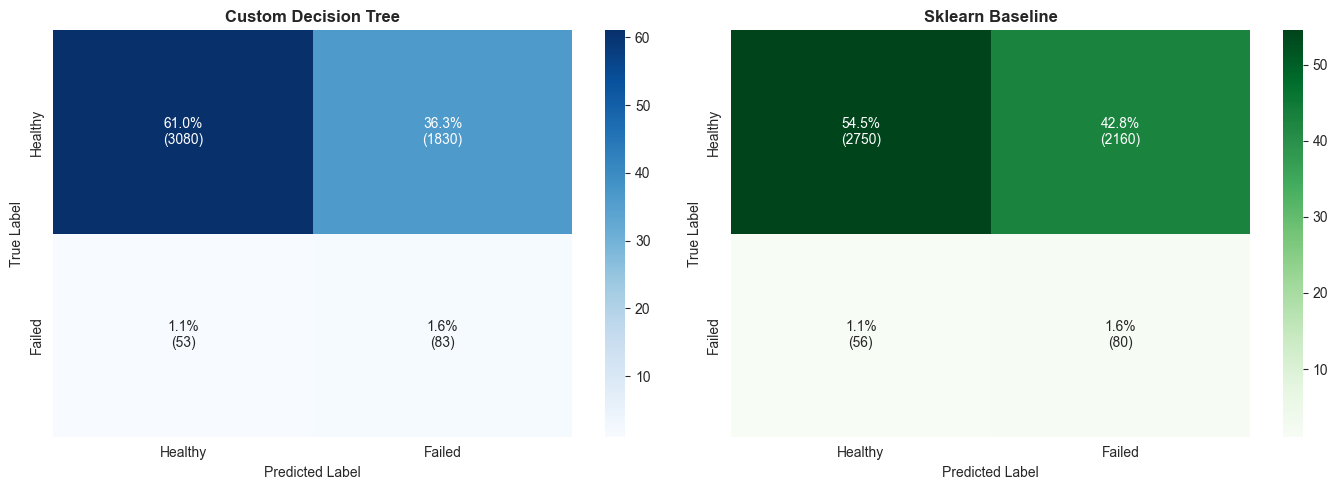


📊 Custom - TP: 83 (1.6%), FP: 1830 (36.3%), TN: 3080 (61.0%), FN: 53 (1.1%)
📊 Sklearn - TP: 80 (1.6%), FP: 2160 (42.8%), TN: 2750 (54.5%), FN: 56 (1.1%)


In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Custom tree confusion matrix
cm_custom = confusion_matrix(y_val, y_val_pred_custom)
cm_custom_pct = cm_custom.astype('float') / cm_custom.sum() * 100
annot_custom = np.array([[f'{pct:.1f}%\n({count})' for pct, count in zip(row_pct, row_count)] 
                         for row_pct, row_count in zip(cm_custom_pct, cm_custom)])
sns.heatmap(cm_custom_pct, annot=annot_custom, fmt='', cmap='Blues', ax=axes[0], 
            xticklabels=['Healthy', 'Failed'], yticklabels=['Healthy', 'Failed'])
axes[0].set_title('Custom Decision Tree', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Sklearn confusion matrix
cm_sklearn = confusion_matrix(y_val, y_val_pred_sklearn)
cm_sklearn_pct = cm_sklearn.astype('float') / cm_sklearn.sum() * 100
annot_sklearn = np.array([[f'{pct:.1f}%\n({count})' for pct, count in zip(row_pct, row_count)] 
                          for row_pct, row_count in zip(cm_sklearn_pct, cm_sklearn)])
sns.heatmap(cm_sklearn_pct, annot=annot_sklearn, fmt='', cmap='Greens', ax=axes[1],
            xticklabels=['Healthy', 'Failed'], yticklabels=['Healthy', 'Failed'])
axes[1].set_title('Sklearn Baseline', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print(f"\n📊 Custom - TP: {cm_custom[1,1]} ({cm_custom_pct[1,1]:.1f}%), FP: {cm_custom[0,1]} ({cm_custom_pct[0,1]:.1f}%), TN: {cm_custom[0,0]} ({cm_custom_pct[0,0]:.1f}%), FN: {cm_custom[1,0]} ({cm_custom_pct[1,0]:.1f}%)")
print(f"📊 Sklearn - TP: {cm_sklearn[1,1]} ({cm_sklearn_pct[1,1]:.1f}%), FP: {cm_sklearn[0,1]} ({cm_sklearn_pct[0,1]:.1f}%), TN: {cm_sklearn[0,0]} ({cm_sklearn_pct[0,0]:.1f}%), FN: {cm_sklearn[1,0]} ({cm_sklearn_pct[1,0]:.1f}%)")

---
## Summary

### ✅ Pipeline Complete!

**What we used:**
1. **Sklearn** for preprocessing (SimpleImputer)
2. **Pandas** for feature engineering
3. **Sklearn** for feature selection (mutual information)
4. **CUSTOM decision tree** implementation (the core contribution)

**Key Achievement:**
- Custom decision tree with class weighting achieves competitive performance with sklearn
- Demonstrates understanding of decision tree algorithms from first principles
- Focus on cost-sensitive learning for imbalanced datasets

**Class Imbalance Handling:**
- Balanced class weights: ~9.4x weight for minority class (failed vehicles)
- Higher recall prioritizes catching failures (like HIV screening test analogy)
- False positives (unnecessary maintenance) better than false negatives (missed failures)

**Next Steps:**
- Implement cost function from research paper (Table 2)
- Add entropy criterion option
- Hyperparameter tuning
- Tree pruning implementation